In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from torchsummary import summary as Summary

**PARAMETERS**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 100  # Standard Approach but will be tuned later
batch_size = 64   # Standard Approach but will be tuned later
lr = 5e-5         # Standard Approach but will be tuned later
img_shape = (3, 32, 32)
n_epochs = 50     # To reduce time and Computational overload 
n_critic = 5      # Standard Approach but will be tuned later
c = 0.01          # Standard Approach but will be tuned later

print(device)

cuda


**FID CALCUALTION**

In [ ]:
# Load Inception-v3 in eval mode for feature extraction process 
inception = inception_v3(pretrained=True, transform_input=False)  
inception.fc = torch.nn.Identity()  # Remove final classification layer
inception.aux_logits = False
inception.eval()

if torch.cuda.is_available():
    inception = inception.cuda()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:04<00:00, 22.5MB/s] 


In [8]:
def preprocess_images(images):
    """Preprocess images for Inception-v3"""
    # Ensure images are in [0, 1] range
    if images.min() >= -1.0 and images.max() <= 1.0:
        # Input is in [-1, 1] range (GAN output)
        images = (images + 1.0) / 2.0
    elif images.max() > 1.0:
        # Input is in [0, 255] range
        images = images / 255.0
    else:
        # Already in [0, 1] range
        pass
    
    # Clamp to [0, 1]
    images = torch.clamp(images, 0.0, 1.0)
    
    # Resize to 299x299
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    
    # ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    
    if images.is_cuda:
        mean = mean.cuda()
        std = std.cuda()
    
    images = (images - mean) / std
    return images

In [ ]:
def get_features(images, model):
    # Extract features using Inception-v3 (2048D from pool3 layer)
    model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            images = images.cuda()
            
        # Preprocess images properly
        images = preprocess_images(images)
        
        # Use the standard forward pass to get pool3 features (2048D)
        features = model(images)  # This gives us the final pooled features
        
        # If features are still 2D (batch_size, features), we're good
        # If they're 4D, we need to pool them
        if len(features.shape) == 4:
            features = F.adaptive_avg_pool2d(features, (1, 1))
            features = torch.flatten(features, 1)
    
    return features.cpu() # Taking it to the cpu because all calculation is going to occur in cpu as numpy is not gpu supported 

In [ ]:
def calculate_stats(features):
    # Calculate mean and covariance matrix
    features = features.numpy().astype(np.float64)  # Use float64 for numerical stability
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

In [ ]:
def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    # Calculate FID score
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)
    
    # Ensure matrices are symmetric (numerical stability)
    sigma1 = (sigma1 + sigma1.T) / 2
    sigma2 = (sigma2 + sigma2.T) / 2
    
    # Add small epsilon to diagonal for numerical stability
    sigma1 += eps * np.eye(sigma1.shape[0])
    sigma2 += eps * np.eye(sigma2.shape[0])
    
    diff = mu1 - mu2
    
    # Calculate sqrt of product of covariance matrices
    try:
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    except Exception as e:
        print(f"Error in sqrtm: {e}")
        # Fallback: add more regularization
        sigma1 += eps * 10 * np.eye(sigma1.shape[0])
        sigma2 += eps * 10 * np.eye(sigma2.shape[0])
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    
    # Handle numerical errors in sqrtm
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.absolute(covmean.imag))
            raise ValueError(f"Imaginary component {m}")
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [ ]:
def compute_fid(real_images, fake_images, batch_size=64):
    # Compute FID between real and fake images 
    # Create data loaders
    real_loader = DataLoader(real_images, batch_size=batch_size, shuffle=False)
    fake_loader = DataLoader(fake_images, batch_size=batch_size, shuffle=False)
    
    # Process real images
    real_features = []
    for batch in real_loader:
        real_features.append(get_features(batch, inception))
    real_features = torch.cat(real_features, dim=0)

    # Process fake images
    fake_features = []
    for batch in fake_loader:
        fake_features.append(get_features(batch, inception))
    fake_features = torch.cat(fake_features, dim=0)

    # Calculate statistics
    mu_real, sigma_real = calculate_stats(real_features)
    mu_fake, sigma_fake = calculate_stats(fake_features)

    return calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)


In [ ]:
def evaluate_fid(generator, dataloader, sample_size, batch_size_fid, latent_dim, device):
    # Evaluate FID score for a generator
    generator.eval()
    
    # Generate fake images
    fake_images = []
    with torch.no_grad():
        for j in range(0, sample_size, batch_size_fid):
            current_batch = min(batch_size_fid, sample_size - j)
            z = torch.randn(current_batch, latent_dim).to(device)
            fake_batch = generator(z).cpu()
            fake_images.append(fake_batch)
    fake_images = torch.cat(fake_images, dim=0)

    # Collect real images
    real_images = []
    total_collected = 0
    for imgs, _ in dataloader:
        real_images.append(imgs)
        total_collected += imgs.size(0)
        if total_collected >= sample_size:
            break
    
    real_images = torch.cat(real_images, dim=0)[:sample_size]
    
    # Ensure we have the same number of real and fake images
    min_size = min(len(real_images), len(fake_images))
    real_images = real_images[:min_size]
    fake_images = fake_images[:min_size]
    
    # Compute FID
    fid = compute_fid(real_images, fake_images)
    
    generator.train()
    return fid

**DATA LOADING**

In [ ]:
selected_classes = [2,3,4,5,6,7] # Selecting Only Animal classes from CIFAR10 to reduce dataset size for reducing the computational cost

class CIFAR10Subset(Dataset):
    def __init__(self, root, train=True, selected_labels=None, transform=None):
        self.full_dataset = datasets.CIFAR10(root=root, train=train, transform=transform, download=True) # from CIFAR10 to CIFAR10Subset
        self.selected_labels = selected_labels if selected_labels is not None else list(range(10))
        self.indices = [i for i, (_, label) in enumerate(self.full_dataset) if label in self.selected_labels]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        true_idx = self.indices[idx]
        img, label = self.full_dataset[true_idx]
        return img, label

transform = transforms.Compose([
    transforms.ToTensor(), # Converting to Tensors 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalisation accross three Channels 
])

subset = CIFAR10Subset(root='./data', train=True, selected_labels=selected_classes, transform=transform)
dataloader = DataLoader(subset, batch_size=64, shuffle=True) # Final dataloader only having 6 classes of Animals - Horse , Bird , Dog , Cat , Deer , Frog

100%|██████████| 170M/170M [00:15<00:00, 11.1MB/s] 


In [ ]:
len(dataloader) * batch_size  # Length Of Dataset

30016

**ARCHITECTURES**

Here We have tried to create different type of architectures and tested there performance on CIFAR 10 through FID score for 50 epochs ... 
All The Architectuaral change and improvement ar described as training proceeds with observation 

In [14]:
class Generator_1(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        if z.ndim == 2:
            z = z.view(z.size(0), z.size(1), 1, 1)
        img = self.model(z)
        return img

generator = Generator_1(latent_dim).to(device)
print(summary(generator, (latent_dim,1,1)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,600
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,288
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
   ConvTranspose2d-7           [-1, 64, 16, 16]         131,072
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]           3,072
             Tanh-11            [-1, 3, 32, 32]               0
Total params: 1,068,928
Trainable params: 1,068,928
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [15]:
class Generator_2(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # Output: 512 x 4 x 4
            
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # Output: 256 x 8 x 8
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Output: 128 x 16 x 16
            
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # Output: 3 x 32 x 32
        )
    
    def forward(self, z):
        if z.ndim == 2:
            z = z.view(z.size(0), z.size(1), 1, 1)
        return self.model(z)

generator = Generator_2(latent_dim).to(device)
print(summary(generator, (latent_dim,1,1)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]           6,144
             Tanh-11            [-1, 3, 32, 32]               0
Total params: 3,448,576
Trainable params: 3,448,576
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [16]:
class Generator_3(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

generator = Generator_3(latent_dim).to(device)
print(summary(generator, input_size=(latent_dim,), batch_size=batch_size, device="cuda"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [64, 8192]         827,392
              ReLU-2                 [64, 8192]               0
         Unflatten-3            [64, 128, 8, 8]               0
          Upsample-4          [64, 128, 16, 16]               0
            Conv2d-5          [64, 128, 16, 16]         147,584
       BatchNorm2d-6          [64, 128, 16, 16]             256
              ReLU-7          [64, 128, 16, 16]               0
          Upsample-8          [64, 128, 32, 32]               0
            Conv2d-9           [64, 64, 32, 32]          73,792
      BatchNorm2d-10           [64, 64, 32, 32]             128
             ReLU-11           [64, 64, 32, 32]               0
           Conv2d-12            [64, 3, 32, 32]           1,731
             Tanh-13            [64, 3, 32, 32]               0
Total params: 1,050,883
Trainable param

In [ ]:
class Generator_4(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.LayerNorm([512, 4, 4]),
            nn.ReLU(True),
            # Output: 512 x 4 x 4
            
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([256, 8, 8]),
            nn.ReLU(True),
            # Output: 256 x 8 x 8
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LayerNorm([128, 16, 16]),
            nn.ReLU(True),
            # Output: 128 x 16 x 16
            
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # Output: 3 x 32 x 32
        )
    
    def forward(self, z):
        if z.ndim == 2:
            z = z.view(z.size(0), z.size(1), 1, 1)
        return self.model(z)

generator = Generator_4(latent_dim).to(device)
print(Summary(generator, (latent_dim,1,1)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
         LayerNorm-2            [-1, 512, 4, 4]          16,384
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
         LayerNorm-5            [-1, 256, 8, 8]          32,768
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
         LayerNorm-8          [-1, 128, 16, 16]          65,536
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]           6,144
             Tanh-11            [-1, 3, 32, 32]               0
Total params: 3,561,472
Trainable params: 3,561,472
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [52]:
class Generator_5(nn.Module):
    def __init__(self, latent_dim):  # 128 is optimal for CIFAR-10
        super().__init__()
        self.latent_dim = latent_dim
        
        # Project latent to initial feature maps
        self.project = nn.Sequential(
            nn.Linear(latent_dim, 512 * 4 * 4),
            nn.Unflatten(1, (512, 4, 4)),
            nn.LayerNorm([512, 4, 4]),
            nn.ReLU(True)
        )
        
        # Main generator network
        self.main = nn.Sequential(
            # Input: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.LayerNorm([256, 8, 8]),
            nn.ReLU(True),
            # 256 x 8 x 8
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.LayerNorm([128, 16, 16]),
            nn.ReLU(True),
            # 128 x 16 x 16
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.LayerNorm([64, 32, 32]),
            nn.ReLU(True),
            # 64 x 32 x 32
            
            nn.ConvTranspose2d(64, 3, 3, 1, 1, bias=False),
            nn.Tanh()
            # Output: 3 x 32 x 32
        )
        
    def forward(self, z):
        # Handle both 2D and 4D input
        if z.ndim == 4:
            z = z.view(z.size(0), -1)
        
        x = self.project(z)
        x = self.main(x)
        return x
        
generator = Generator_5(latent_dim).to(device)  # Pass it explicitly
print(Summary(generator, (latent_dim,)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]         827,392
         Unflatten-2            [-1, 512, 4, 4]               0
         LayerNorm-3            [-1, 512, 4, 4]          16,384
              ReLU-4            [-1, 512, 4, 4]               0
   ConvTranspose2d-5            [-1, 256, 8, 8]       2,097,152
         LayerNorm-6            [-1, 256, 8, 8]          32,768
              ReLU-7            [-1, 256, 8, 8]               0
   ConvTranspose2d-8          [-1, 128, 16, 16]         524,288
         LayerNorm-9          [-1, 128, 16, 16]          65,536
             ReLU-10          [-1, 128, 16, 16]               0
  ConvTranspose2d-11           [-1, 64, 32, 32]         131,072
        LayerNorm-12           [-1, 64, 32, 32]         131,072
             ReLU-13           [-1, 64, 32, 32]               0
  ConvTranspose2d-14            [-1, 3,

In [17]:
class Critic_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten()
        )

    def forward(self, x):
        return self.model(x)

critic = Critic_1().to(device)
print(summary(critic, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           1,536
         LeakyReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          32,768
       BatchNorm2d-4             [-1, 64, 8, 8]             128
         LeakyReLU-5             [-1, 64, 8, 8]               0
            Conv2d-6            [-1, 128, 4, 4]         131,072
       BatchNorm2d-7            [-1, 128, 4, 4]             256
         LeakyReLU-8            [-1, 128, 4, 4]               0
            Conv2d-9              [-1, 1, 1, 1]           2,048
          Flatten-10                    [-1, 1]               0
Total params: 167,808
Trainable params: 167,808
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.27
Params size (MB): 0.64
Estimated T

In [18]:
class Critic_2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 16 x 16
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 8 x 8
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 4 x 4
            
            # Global average pooling instead of another conv layer
            nn.AdaptiveAvgPool2d(1),  # 256 x 1 x 1
            nn.Flatten(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)

critic = Critic_2().to(device)
print(summary(critic, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,072
         LeakyReLU-2           [-1, 64, 16, 16]               0
            Conv2d-3            [-1, 128, 8, 8]         131,072
       BatchNorm2d-4            [-1, 128, 8, 8]             256
         LeakyReLU-5            [-1, 128, 8, 8]               0
            Conv2d-6            [-1, 256, 4, 4]         524,288
       BatchNorm2d-7            [-1, 256, 4, 4]             512
         LeakyReLU-8            [-1, 256, 4, 4]               0
 AdaptiveAvgPool2d-9            [-1, 256, 1, 1]               0
          Flatten-10                  [-1, 256]               0
           Linear-11                    [-1, 1]             257
Total params: 659,457
Trainable params: 659,457
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [19]:
class Critic_3(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 64, kernel_size=4, stride=1, padding=1, bias=False),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 16 x 16
            
            nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=1, bias=False),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 8 x 8
            
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=1, bias=False),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 4 x 4
            
            # Global average pooling instead of another conv layer
            nn.AdaptiveAvgPool2d(1),  # 256 x 1 x 1
            nn.Flatten(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)

critic = Critic_3().to(device)
print(summary(critic, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]           3,072
         MaxPool2d-2           [-1, 64, 15, 15]               0
         LeakyReLU-3           [-1, 64, 15, 15]               0
            Conv2d-4          [-1, 128, 14, 14]         131,072
         MaxPool2d-5            [-1, 128, 6, 6]               0
       BatchNorm2d-6            [-1, 128, 6, 6]             256
         LeakyReLU-7            [-1, 128, 6, 6]               0
            Conv2d-8            [-1, 256, 5, 5]         524,288
         MaxPool2d-9            [-1, 256, 2, 2]               0
      BatchNorm2d-10            [-1, 256, 2, 2]             512
        LeakyReLU-11            [-1, 256, 2, 2]               0
AdaptiveAvgPool2d-12            [-1, 256, 1, 1]               0
          Flatten-13                  [-1, 256]               0
           Linear-14                   

In [ ]:
from torch.nn.utils import spectral_norm
from torchinfo import summary

class GroupSort(nn.Module):
    def __init__(self, groups=2):
        super().__init__()
        self.groups = groups
        
    def forward(self, x):
        shape = x.shape
        x_flat = x.reshape(shape[0], self.groups, -1)
        return torch.sort(x_flat, dim=-1).values.reshape(shape)

class Critic_4(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 64, 4, 2, 1, bias=False)),
            GroupSort(2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            GroupSort(2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            GroupSort(4),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            spectral_norm(nn.Linear(256, 1, bias=False))
        )

    def forward(self, x):  
        return self.model(x)

critic = Critic_4().to(device)
# Verify with test input first
test_input = torch.randn(1, 3, 32, 32).to(device)
output = critic(test_input)
print("Test output shape:", output.shape)  # Should be (1, 1)
# Now use torchinfo
summary(critic, input_size=(1, 3, 32, 32))

Test output shape: torch.Size([1, 1])


Layer (type:depth-idx)                   Output Shape              Param #
Critic_4                                 [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Conv2d: 2-1                       [1, 64, 16, 16]           3,072
│    └─GroupSort: 2-2                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-3                       [1, 128, 8, 8]            131,072
│    └─GroupSort: 2-4                    [1, 128, 8, 8]            --
│    └─Conv2d: 2-5                       [1, 256, 4, 4]            524,288
│    └─GroupSort: 2-6                    [1, 256, 4, 4]            --
│    └─AdaptiveAvgPool2d: 2-7            [1, 256, 1, 1]            --
│    └─Flatten: 2-8                      [1, 256]                  --
│    └─Linear: 2-9                       [1, 1]                    256
Total params: 658,688
Trainable params: 658,688
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 151.19
Input size (MB): 0.01
Forwa

In [53]:
class Critic_5(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
        spectral_norm(nn.Conv2d(3, 64, 4, 2, 1, bias=False)),  # 32→16
        nn.LayerNorm([64, 16, 16]),
        nn.LeakyReLU(0.2, inplace=True),
        
        spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),  # 16→8
        nn.LayerNorm([128, 8, 8]),
        nn.LeakyReLU(0.2, inplace=True),
        
        spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),  # 8→4
        nn.LayerNorm([256, 4, 4]),
        nn.LeakyReLU(0.2, inplace=True),
        
        spectral_norm(nn.Conv2d(256, 512, 4, 2, 1, bias=False)),  # 4→2
        nn.LayerNorm([512, 2, 2]),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.AdaptiveAvgPool2d(1),  # 512x1x1
        nn.Flatten(),
        spectral_norm(nn.Linear(512, 1, bias=False))  # Must match 512
    )
        
    def forward(self, x):
        return self.model(x)

critic = Critic_5().to(device)
print(Summary(critic, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,072
         LayerNorm-2           [-1, 64, 16, 16]          32,768
         LeakyReLU-3           [-1, 64, 16, 16]               0
            Conv2d-4            [-1, 128, 8, 8]         131,072
         LayerNorm-5            [-1, 128, 8, 8]          16,384
         LeakyReLU-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 4, 4]         524,288
         LayerNorm-8            [-1, 256, 4, 4]           8,192
         LeakyReLU-9            [-1, 256, 4, 4]               0
           Conv2d-10            [-1, 512, 2, 2]       2,097,152
        LayerNorm-11            [-1, 512, 2, 2]           4,096
        LeakyReLU-12            [-1, 512, 2, 2]               0
AdaptiveAvgPool2d-13            [-1, 512, 1, 1]               0
          Flatten-14                  [

**TRAINING FUNCTION**

In [21]:
def show_imgs(real_imgs, gen_imgs, n=10):
    """Display real and generated images side by side"""
    n = min(n, len(real_imgs), len(gen_imgs))  # Ensure we don't exceed available images
    
    real = real_imgs[:n].cpu().detach()
    fake = gen_imgs[:n].cpu().detach()

    # Rescale from [-1, 1] to [0, 1]
    real = (real + 1) / 2
    fake = (fake + 1) / 2

    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))
    
    # Handle case where n=1 (axes won't be 2D)
    if n == 1:
        axes = axes.reshape(2, 1)

    for i in range(n):
        # Real images on top row
        real_img = real[i].permute(1, 2, 0).numpy()
        axes[0, i].imshow(real_img, vmin=0, vmax=1)
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Real Images")

        # Fake images on bottom row
        fake_img = fake[i].permute(1, 2, 0).numpy()
        axes[1, i].imshow(fake_img, vmin=0, vmax=1)
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Generated Images")

    plt.tight_layout()
    plt.show()


In [ ]:
def train_WGAN(generator, critic, optimizer_g, optimizer_c, dataloader, device, latent_dim, n_critic , c , n_epochs , fid_0):
    os.makedirs("images_WGAN", exist_ok=True)

    g_losses = []  
    c_losses = []
    fid_scores = []
    fid_scores.append(fid_0)  # Adding the fid value of noise genertaed by the generator before Training 

    for epoch in range(1 , n_epochs+1):
        g_loss_epoch = 0.0  # Intialised the loss variables 
        c_loss_epoch = 0.0
        batches = 0
        
        for i, (imgs, _) in enumerate(dataloader): 
            real_imgs = imgs.to(device)
            batches += 1
            c_loss_n = 0.0
            b_size = imgs.size(0)  # to track the current batch size

            for _ in range(n_critic):
                optimizer_c.zero_grad()
 
                z = torch.randn(b_size, latent_dim).to(device)
                fake_imgs = generator(z).detach()

                real_validity = critic(real_imgs)
                fake_validity = critic(fake_imgs)

                loss_c = - (torch.mean(real_validity) - torch.mean(fake_validity))   # loss of Critic = max ( E(D(x)) - E(G(z)) )
                c_loss_n += loss_c.item()                                            # maximising the loss = minimising the the -ve of loss as optimizers are used to reduce the loss values 
                loss_c.backward()                                                                   
                optimizer_c.step()

                for p in critic.parameters():           # Weight Clipping 
                    p.data.clamp_(-c, c)

            c_loss_epoch += (c_loss_n / n_critic)   # taking Avg of all the losses for n_critic

            optimizer_g.zero_grad()
            z = torch.randn(b_size, latent_dim).to(device)
            gen_imgs = generator(z)
            gen_validity = critic(gen_imgs)
            loss_g = - torch.mean(gen_validity)   # loss of Generator = min( - E(D(G(z))) ) 
            g_loss_epoch += loss_g.item()         # and we will keep it as it is as optimisers are already doing this 
            loss_g.backward()
            optimizer_g.step()
            
        avg_c_loss = c_loss_epoch / batches
        avg_g_loss = g_loss_epoch / batches

        g_losses.append(avg_g_loss)
        c_losses.append(avg_c_loss)
        
        fid_score = evaluate_fid(generator, dataloader, 5000 , 100 , latent_dim, device)  # Computing the FID in each epoch 
        fid_scores.append(fid_score)

        print(f"[Epoch {epoch}/{n_epochs}] Loss D: {avg_c_loss:.4f}, Loss G: {avg_g_loss:.4f} , FID score : {fid_score:.4f}")

        # Printing The Results for every 25th iteration

        if epoch % 25 == 0:
            noise = torch.randn(15,latent_dim).to(device)
            with torch.no_grad():
              gen_images = generator(noise).to(device)
            save_image(gen_images.data[:10], f"images_WGAN/{epoch}.png", nrow=5, normalize=True)
            show_imgs(real_imgs, gen_images, n=10)

    # Plotting The Curves 

    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(c_losses, label='Critic Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("WGAN Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label='FID Score')
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID Score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return fid_scores

**TRAINING AND TESTING**

First we have tried  with a small size low parameter random architecture ... 

Before Training...


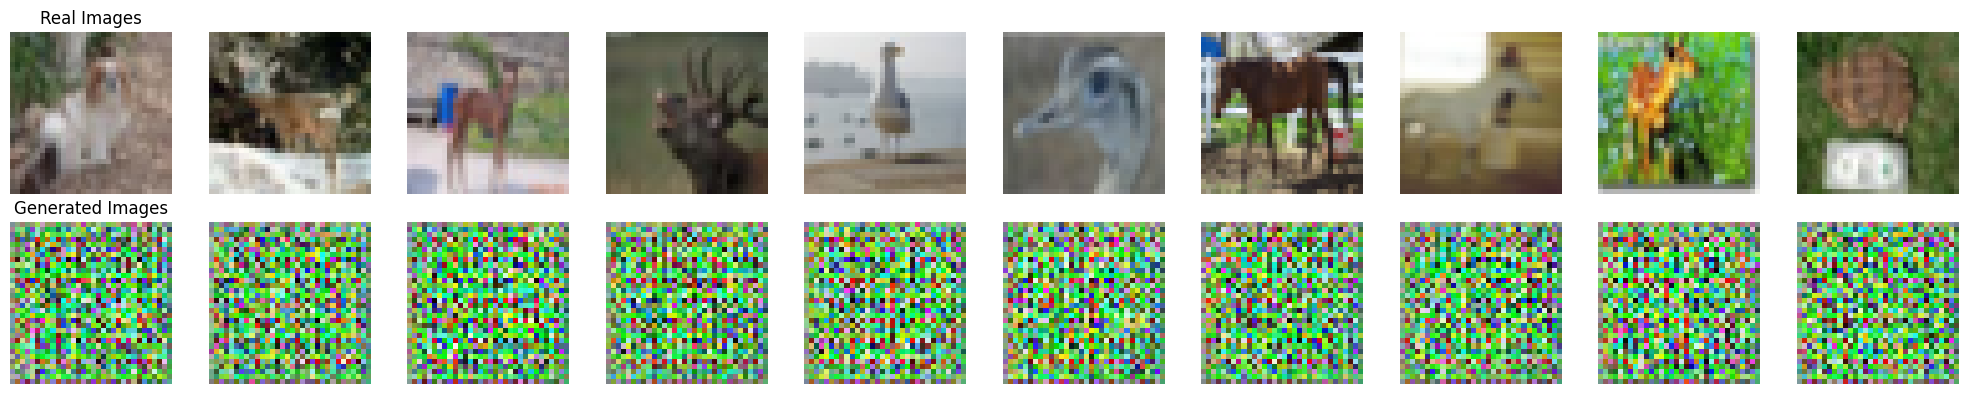

 FID : 547.1065115573783
Training started...
[Epoch 1/50] Loss D: -0.1265, Loss G: 0.0679 , FID score : 275.4382
[Epoch 2/50] Loss D: -0.1519, Loss G: 0.0771 , FID score : 277.7646
[Epoch 3/50] Loss D: -0.1420, Loss G: 0.0687 , FID score : 236.7889
[Epoch 4/50] Loss D: -0.1229, Loss G: 0.0591 , FID score : 246.1004
[Epoch 5/50] Loss D: -0.0999, Loss G: 0.0481 , FID score : 227.2553
[Epoch 6/50] Loss D: -0.0850, Loss G: 0.0408 , FID score : 207.9197
[Epoch 7/50] Loss D: -0.0750, Loss G: 0.0357 , FID score : 199.1338
[Epoch 8/50] Loss D: -0.0691, Loss G: 0.0320 , FID score : 195.1876
[Epoch 9/50] Loss D: -0.0704, Loss G: 0.0303 , FID score : 193.5848
[Epoch 10/50] Loss D: -0.0715, Loss G: 0.0314 , FID score : 187.1494
[Epoch 11/50] Loss D: -0.0708, Loss G: 0.0311 , FID score : 181.0242
[Epoch 12/50] Loss D: -0.0689, Loss G: 0.0302 , FID score : 176.3890
[Epoch 13/50] Loss D: -0.0662, Loss G: 0.0288 , FID score : 173.4955
[Epoch 14/50] Loss D: -0.0626, Loss G: 0.0270 , FID score : 171.619

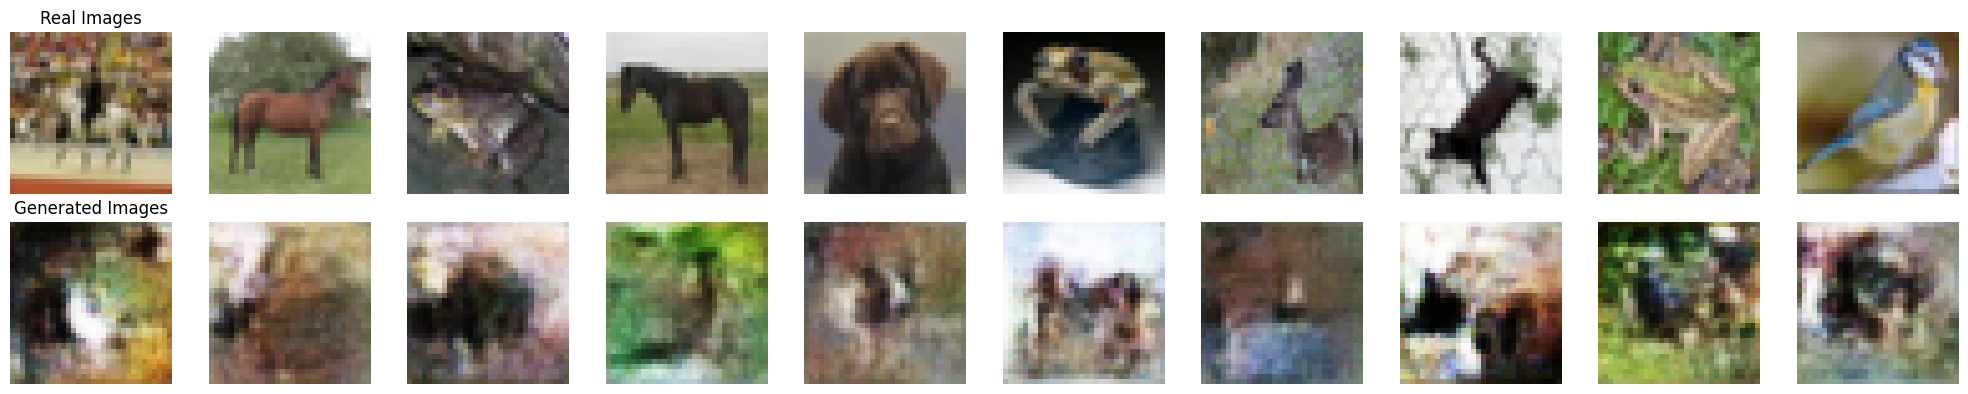

[Epoch 26/50] Loss D: -0.0317, Loss G: 0.0149 , FID score : 131.6239
[Epoch 27/50] Loss D: -0.0263, Loss G: 0.0125 , FID score : 134.2655
[Epoch 28/50] Loss D: -0.0269, Loss G: 0.0137 , FID score : 133.6775
[Epoch 29/50] Loss D: -0.0299, Loss G: 0.0152 , FID score : 133.6137
[Epoch 30/50] Loss D: -0.0320, Loss G: 0.0158 , FID score : 134.2271
[Epoch 31/50] Loss D: -0.0341, Loss G: 0.0170 , FID score : 135.1003
[Epoch 32/50] Loss D: -0.0349, Loss G: 0.0184 , FID score : 126.5545
[Epoch 33/50] Loss D: -0.0345, Loss G: 0.0187 , FID score : 125.4331
[Epoch 34/50] Loss D: -0.0333, Loss G: 0.0180 , FID score : 124.5312
[Epoch 35/50] Loss D: -0.0326, Loss G: 0.0183 , FID score : 121.8604
[Epoch 36/50] Loss D: -0.0318, Loss G: 0.0175 , FID score : 121.4110
[Epoch 37/50] Loss D: -0.0305, Loss G: 0.0170 , FID score : 119.7015
[Epoch 38/50] Loss D: -0.0290, Loss G: 0.0157 , FID score : 120.0539
[Epoch 39/50] Loss D: -0.0278, Loss G: 0.0152 , FID score : 113.4817
[Epoch 40/50] Loss D: -0.0269, Los

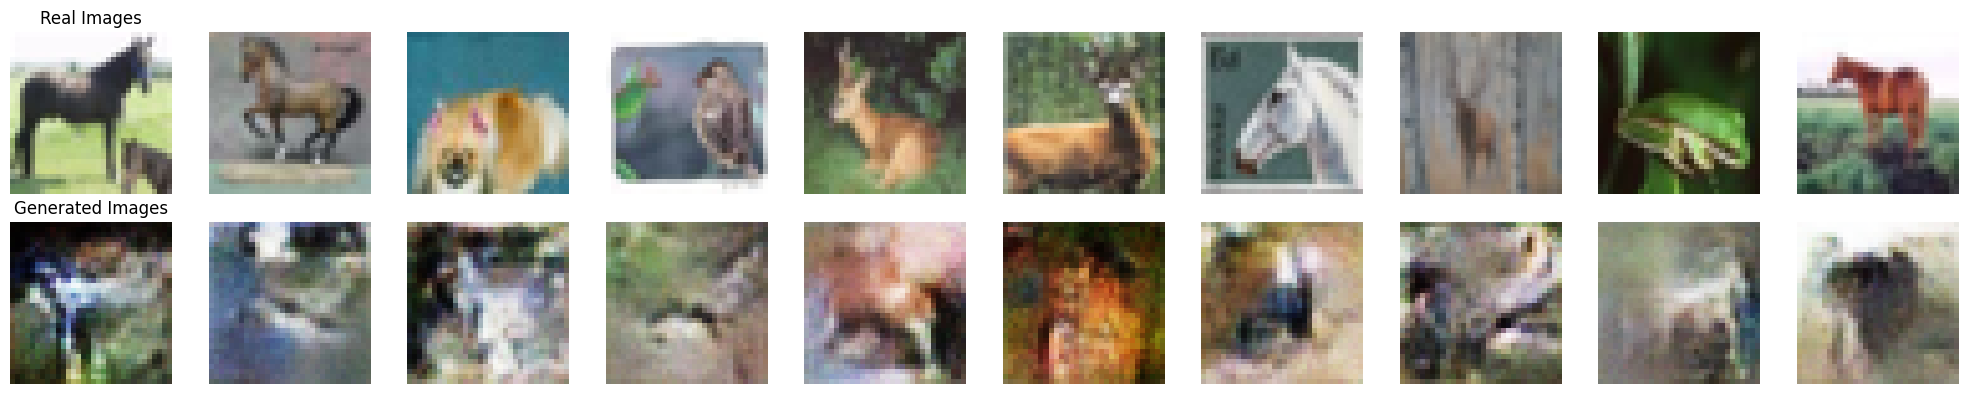

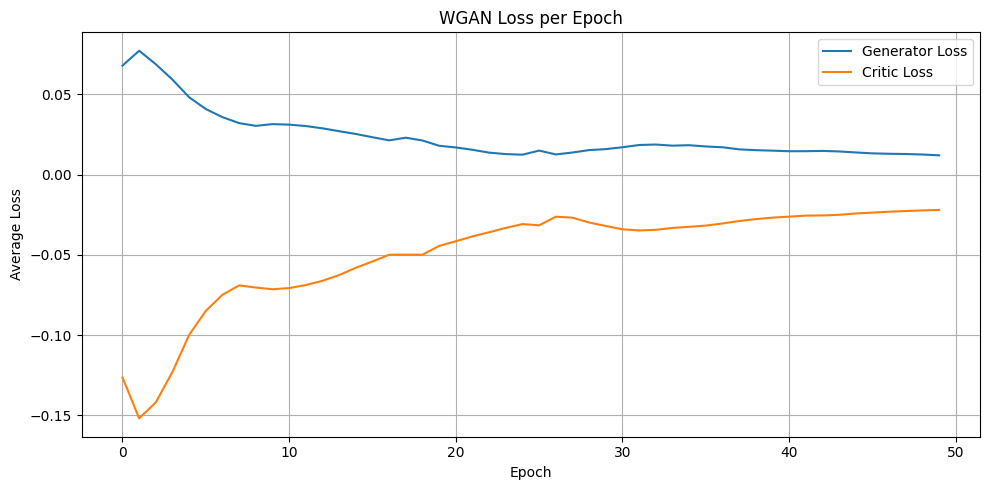

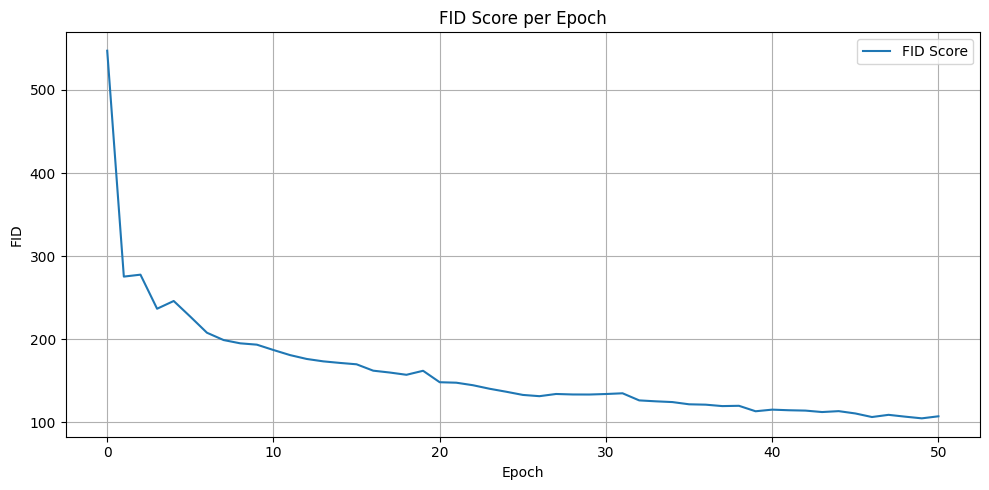

In [31]:
generator_1 = Generator_1(latent_dim).to(device)
critic_1 = Critic_1().to(device)
optimizer_g1 = optim.RMSprop(generator_1.parameters(), lr=lr)
optimizer_c1 = optim.RMSprop(critic_1.parameters(), lr=lr)

with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(device)
    gen_imgs = generator_1(noise)

# Get real images for comparison
for imgs, _ in dataloader:
    real_imgs = imgs.to(device)
    break
print("Before Training...")
val = evaluate_fid(generator_1, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val}")
print("Training started...")

# Start training
fid_1 = train_WGAN(generator_1, critic_1, optimizer_g1, optimizer_c1, dataloader, device, latent_dim, n_critic , c , n_epochs , val)

**OBSERVATION_1**

1. Convergence is not well 
2. Low parameter Architecture 
3. Stable Training may converge better with longer epoch 
4. Convulational Layers managing sharp edges 

for faster convergence we need little more optimization -- Increasing The width of neural network (Architecture 2)

Before Training...


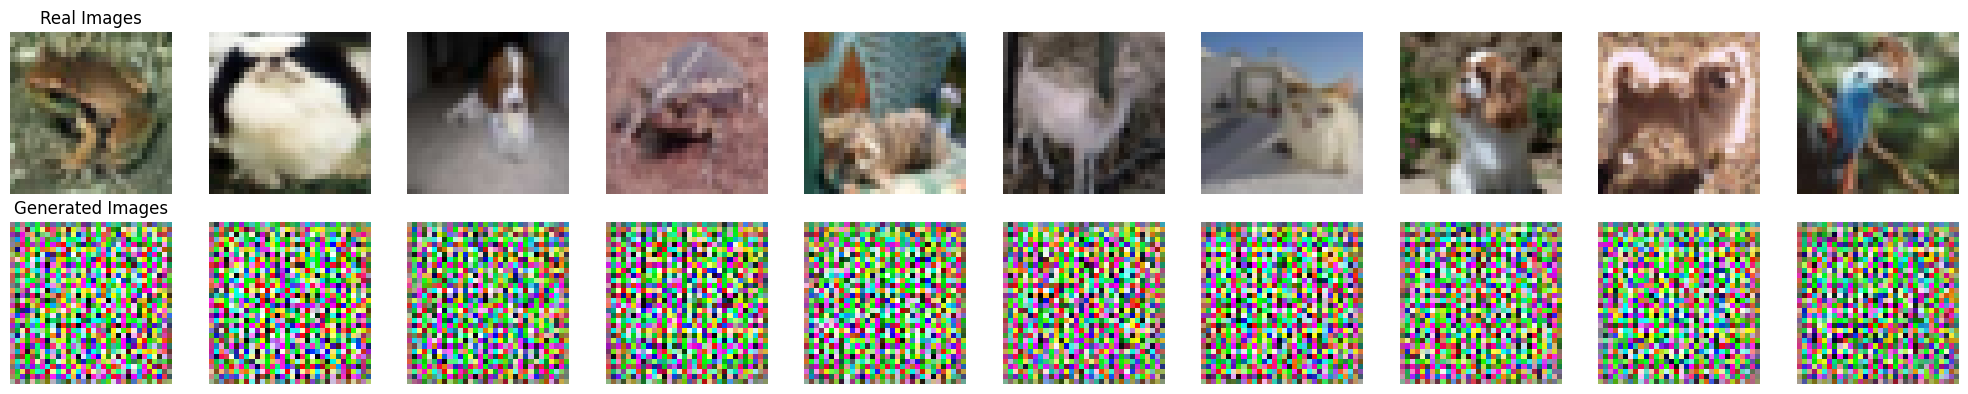

 FID : 550.4091370880814
Training started...
[Epoch 1/50] Loss D: -0.0036, Loss G: 0.0116 , FID score : 235.1995
[Epoch 2/50] Loss D: -0.0059, Loss G: 0.0128 , FID score : 208.6249
[Epoch 3/50] Loss D: -0.0067, Loss G: 0.0133 , FID score : 208.3247
[Epoch 4/50] Loss D: -0.0077, Loss G: 0.0138 , FID score : 229.5069
[Epoch 5/50] Loss D: -0.0075, Loss G: 0.0137 , FID score : 193.8019
[Epoch 6/50] Loss D: -0.0071, Loss G: 0.0135 , FID score : 215.6414
[Epoch 7/50] Loss D: -0.0074, Loss G: 0.0136 , FID score : 184.6699
[Epoch 8/50] Loss D: -0.0073, Loss G: 0.0136 , FID score : 187.7585
[Epoch 9/50] Loss D: -0.0078, Loss G: 0.0139 , FID score : 179.3028
[Epoch 10/50] Loss D: -0.0074, Loss G: 0.0137 , FID score : 165.8455
[Epoch 11/50] Loss D: -0.0072, Loss G: 0.0136 , FID score : 176.7488
[Epoch 12/50] Loss D: -0.0069, Loss G: 0.0135 , FID score : 159.3271
[Epoch 13/50] Loss D: -0.0069, Loss G: 0.0135 , FID score : 157.6305
[Epoch 14/50] Loss D: -0.0064, Loss G: 0.0132 , FID score : 155.022

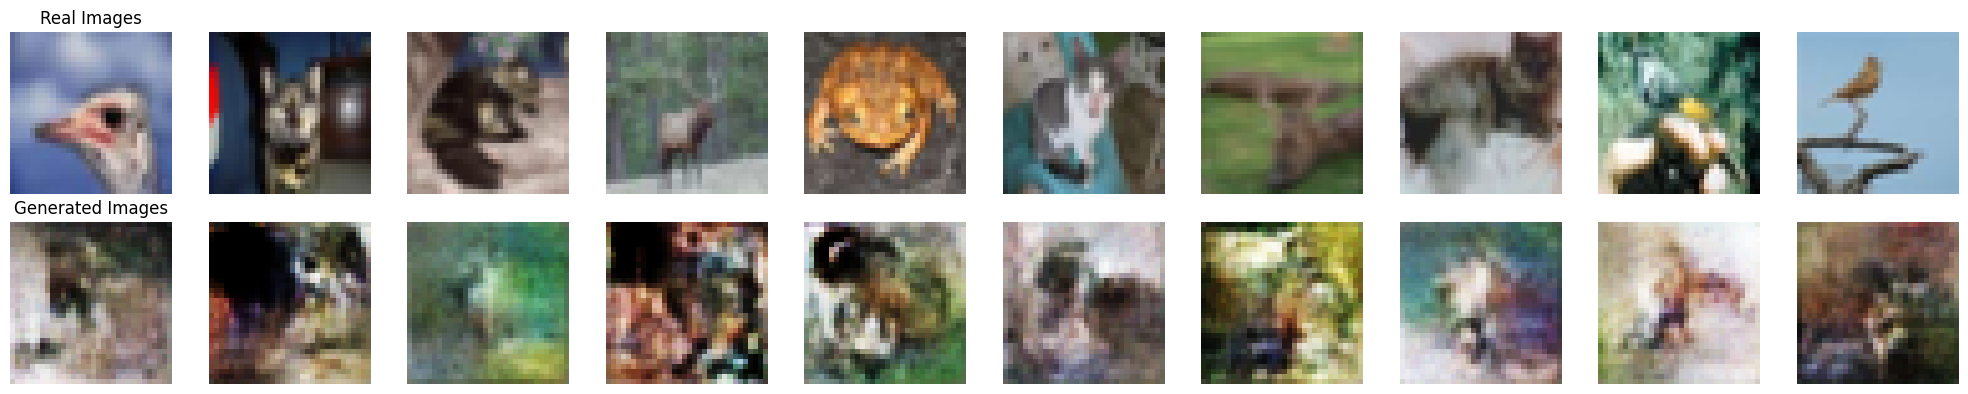

[Epoch 26/50] Loss D: -0.0036, Loss G: 0.0118 , FID score : 117.0090
[Epoch 27/50] Loss D: -0.0042, Loss G: 0.0122 , FID score : 117.3059
[Epoch 28/50] Loss D: -0.0035, Loss G: 0.0117 , FID score : 108.2572
[Epoch 29/50] Loss D: -0.0034, Loss G: 0.0117 , FID score : 107.9458
[Epoch 30/50] Loss D: -0.0032, Loss G: 0.0117 , FID score : 108.9967
[Epoch 31/50] Loss D: -0.0032, Loss G: 0.0116 , FID score : 106.3244
[Epoch 32/50] Loss D: -0.0031, Loss G: 0.0116 , FID score : 102.2810
[Epoch 33/50] Loss D: -0.0031, Loss G: 0.0116 , FID score : 102.7262
[Epoch 34/50] Loss D: -0.0030, Loss G: 0.0116 , FID score : 97.2689
[Epoch 35/50] Loss D: -0.0030, Loss G: 0.0115 , FID score : 99.7086
[Epoch 36/50] Loss D: -0.0030, Loss G: 0.0115 , FID score : 95.1844
[Epoch 37/50] Loss D: -0.0029, Loss G: 0.0114 , FID score : 96.4854
[Epoch 38/50] Loss D: -0.0030, Loss G: 0.0115 , FID score : 94.8495
[Epoch 39/50] Loss D: -0.0030, Loss G: 0.0114 , FID score : 92.5420
[Epoch 40/50] Loss D: -0.0030, Loss G: 0

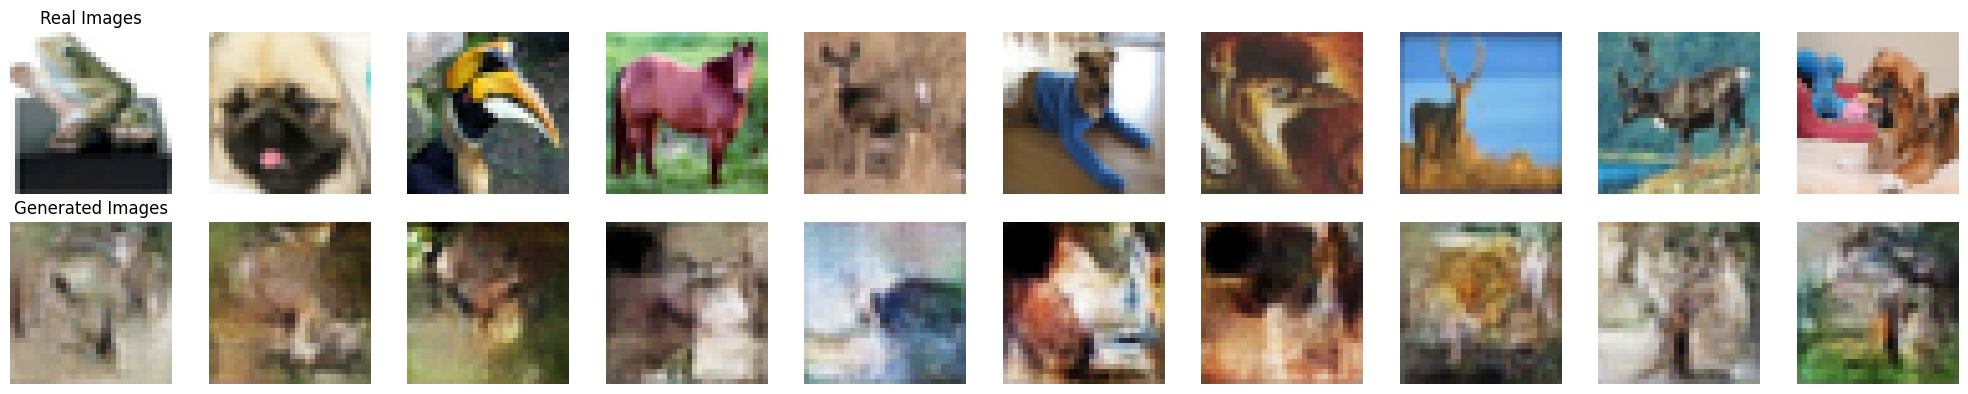

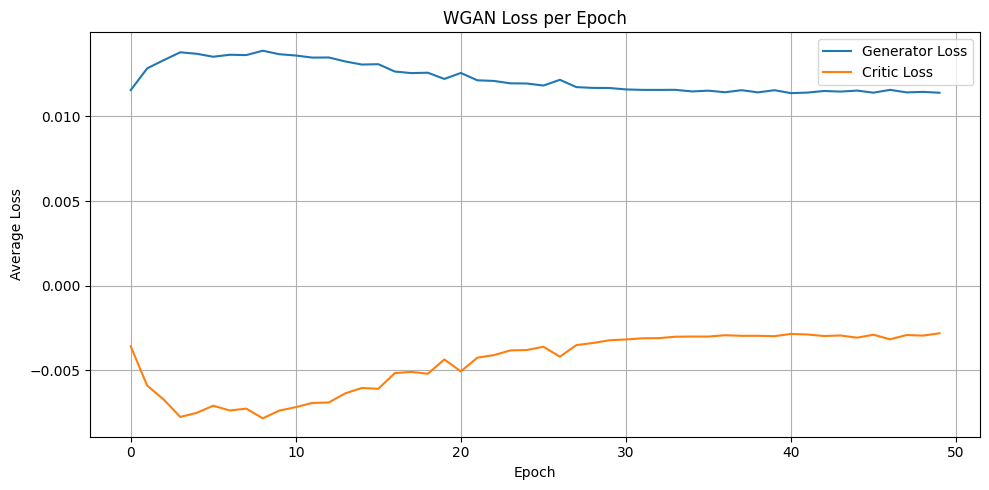

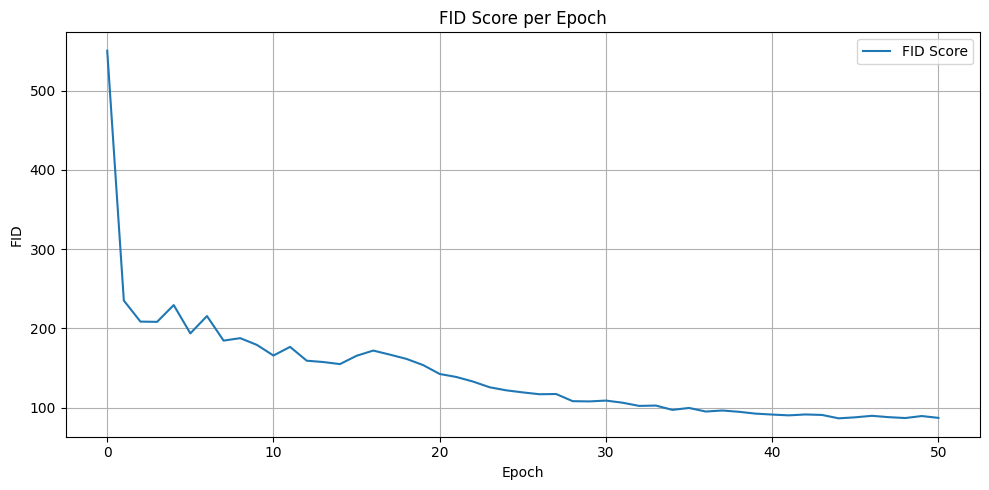

In [22]:
generator_2 = Generator_2(latent_dim).to(device)
critic_2 = Critic_2().to(device)
optimizer_g2 = optim.RMSprop(generator_2.parameters(), lr=lr)
optimizer_c2 = optim.RMSprop(critic_2.parameters(), lr=lr)

generator = generator_2.to(device)
batch_size = 20
noise = torch.randn(batch_size,latent_dim).to(device)
gen_imgs = generator(noise).to(device)
for i, (imgs, _) in enumerate(dataloader):
    real_imgs = imgs.to(device)
    break
    
print("Before Training...")
val = evaluate_fid(generator_2, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val}")
print("Training started...")

# Start training
fid_2 = train_WGAN(generator_2, critic_2, optimizer_g2, optimizer_c2, dataloader, device, latent_dim, n_critic , c , n_epochs , val)

**OBSERVATION_2**

1. Improvement in FID score 
2. Little fluctuation in the beginning but stabilised later 
3. Converges better but not up to the mark

So trying a differnt Type of Architecture (ARchitecture 3) removing ConvTranspose and applying Upsampling (with scale factor 2) + Convolution Operation  and Classical Maxpool Operation in Critic 

Before Training...


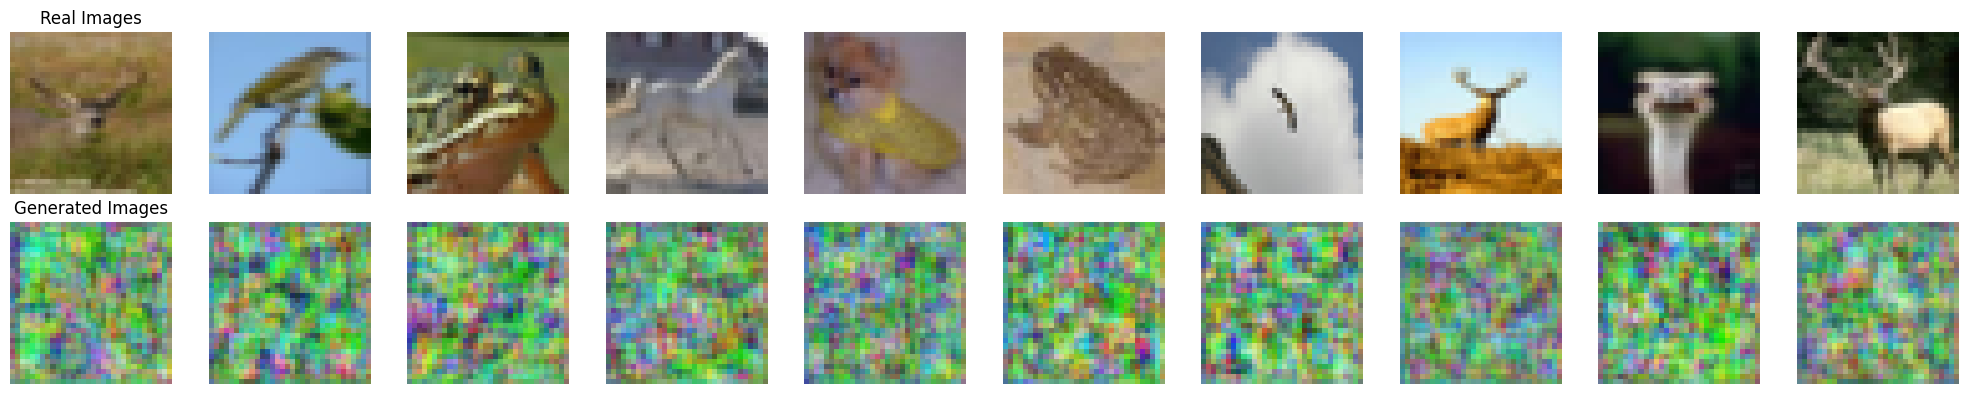

 FID : 432.0726590184677
Training started...
[Epoch 1/50] Loss D: -0.0034, Loss G: -0.0069 , FID score : 138.2267
[Epoch 2/50] Loss D: -0.0047, Loss G: -0.0064 , FID score : 126.9285
[Epoch 3/50] Loss D: -0.0047, Loss G: -0.0065 , FID score : 108.0012
[Epoch 4/50] Loss D: -0.0048, Loss G: -0.0064 , FID score : 113.4775
[Epoch 5/50] Loss D: -0.0046, Loss G: -0.0065 , FID score : 111.2900
[Epoch 6/50] Loss D: -0.0046, Loss G: -0.0065 , FID score : 109.6890
[Epoch 7/50] Loss D: -0.0046, Loss G: -0.0065 , FID score : 112.5967
[Epoch 8/50] Loss D: -0.0045, Loss G: -0.0065 , FID score : 102.8427
[Epoch 9/50] Loss D: -0.0043, Loss G: -0.0066 , FID score : 103.0980
[Epoch 10/50] Loss D: -0.0042, Loss G: -0.0067 , FID score : 91.5883
[Epoch 11/50] Loss D: -0.0041, Loss G: -0.0068 , FID score : 91.7257
[Epoch 12/50] Loss D: -0.0039, Loss G: -0.0069 , FID score : 91.3300
[Epoch 13/50] Loss D: -0.0038, Loss G: -0.0069 , FID score : 90.2988
[Epoch 14/50] Loss D: -0.0037, Loss G: -0.0070 , FID score

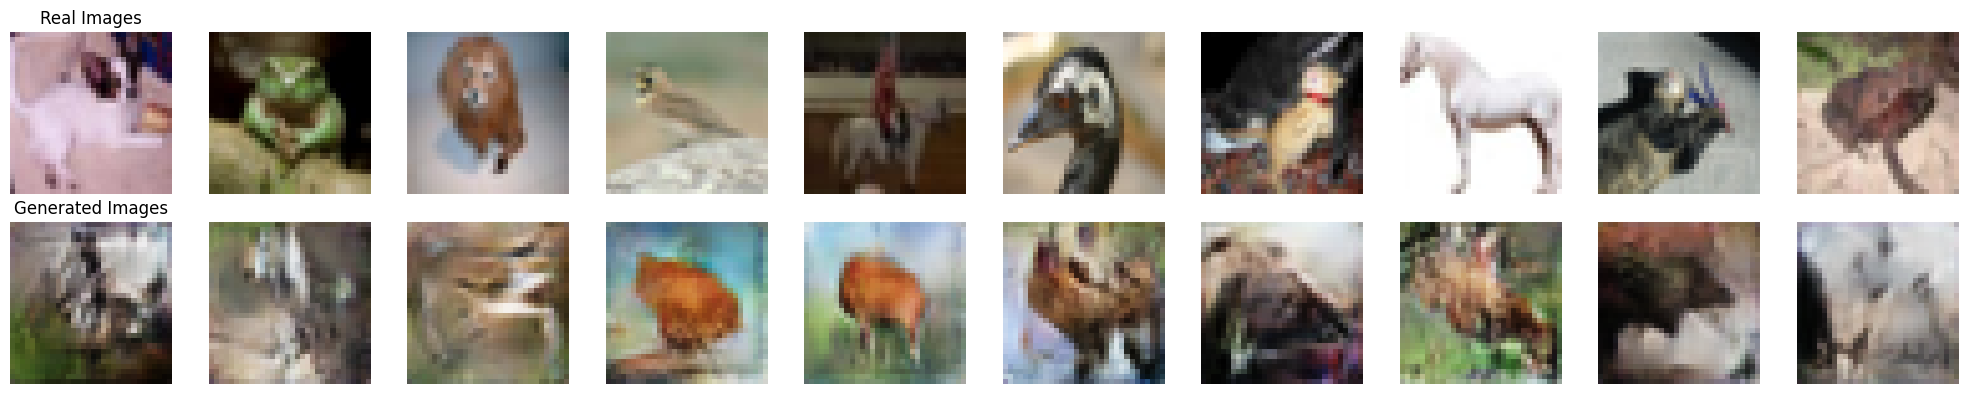

[Epoch 26/50] Loss D: -0.0029, Loss G: -0.0073 , FID score : 64.3567
[Epoch 27/50] Loss D: -0.0029, Loss G: -0.0072 , FID score : 67.5728
[Epoch 28/50] Loss D: -0.0028, Loss G: -0.0073 , FID score : 64.0653
[Epoch 29/50] Loss D: -0.0028, Loss G: -0.0072 , FID score : 66.8372
[Epoch 30/50] Loss D: -0.0028, Loss G: -0.0073 , FID score : 61.2272
[Epoch 31/50] Loss D: -0.0028, Loss G: -0.0072 , FID score : 59.6413
[Epoch 32/50] Loss D: -0.0027, Loss G: -0.0073 , FID score : 67.9000
[Epoch 33/50] Loss D: -0.0027, Loss G: -0.0073 , FID score : 64.6780
[Epoch 34/50] Loss D: -0.0027, Loss G: -0.0073 , FID score : 61.1073
[Epoch 35/50] Loss D: -0.0027, Loss G: -0.0073 , FID score : 62.7150
[Epoch 36/50] Loss D: -0.0027, Loss G: -0.0073 , FID score : 60.5874
[Epoch 37/50] Loss D: -0.0026, Loss G: -0.0073 , FID score : 62.7282
[Epoch 38/50] Loss D: -0.0026, Loss G: -0.0073 , FID score : 55.0236
[Epoch 39/50] Loss D: -0.0026, Loss G: -0.0073 , FID score : 63.5795
[Epoch 40/50] Loss D: -0.0026, Los

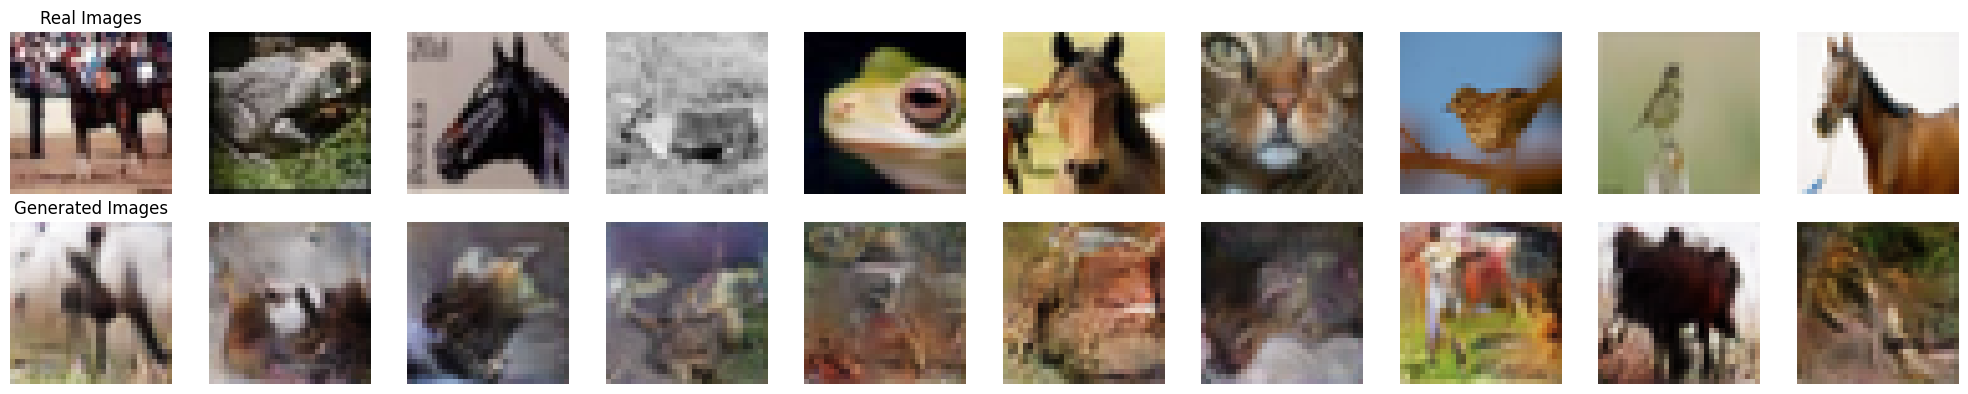

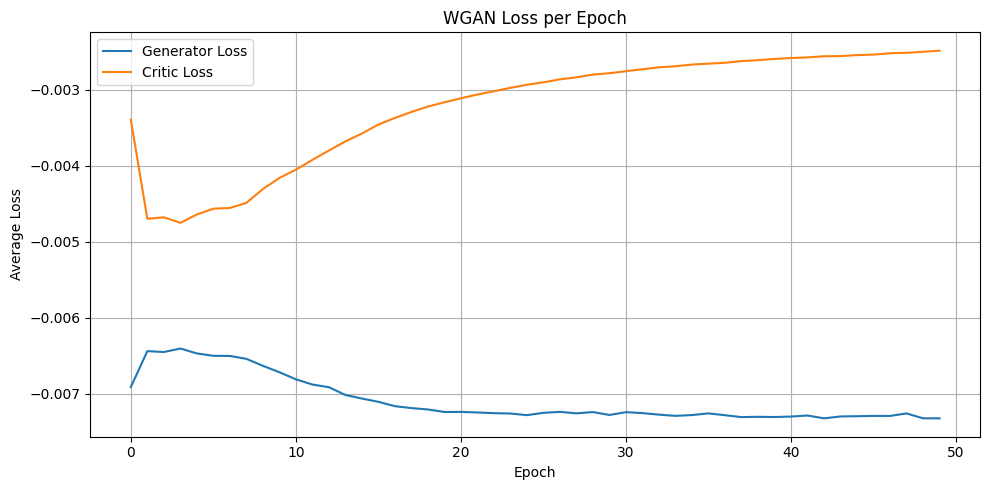

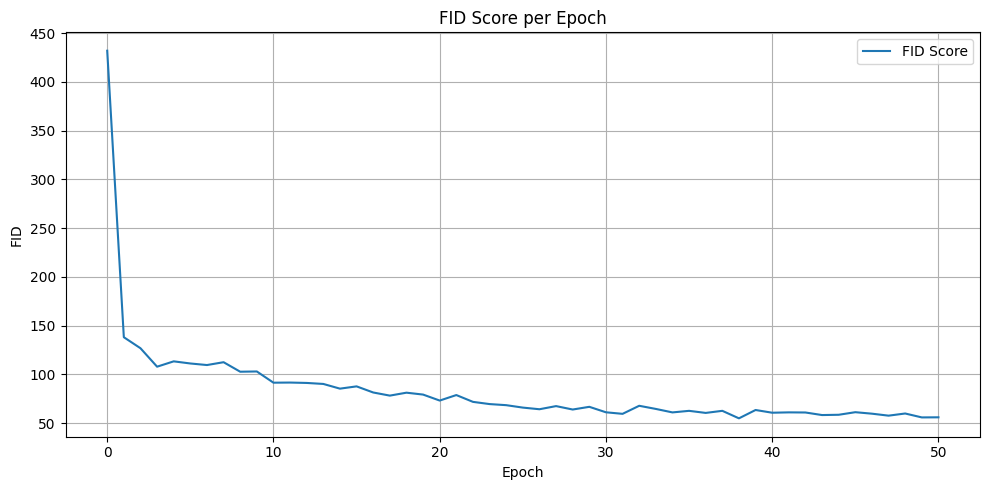

In [61]:
generator_3 = Generator_3(latent_dim).to(device)
critic_3 = Critic_3().to(device)
optimizer_g3 = optim.RMSprop(generator_3.parameters(), lr=lr)
optimizer_c3 = optim.RMSprop(critic_3.parameters(), lr=lr)

generator = generator_3.to(device)
batch_size = 20
noise = torch.randn(batch_size,latent_dim).to(device)
gen_imgs = generator(noise).to(device)
for i, (imgs, _) in enumerate(dataloader):
    real_imgs = imgs.to(device)
    break
    
print("Before Training...")
val = evaluate_fid(generator_3, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val}")
print("Training started...")
# Start training
fid_3 = train_WGAN(generator_3, critic_3, optimizer_g3, optimizer_c3, dataloader, device, latent_dim, n_critic , c , n_epochs , val)

**OBSERVATION_3**

1. Improvement in FID score (Best FID so far)
2. little Flactuation and early saturation in Generator losss 
3. FID drops drastically in early epochs and saturated at 60s range after 25th epoch
4. Critic loss was increasing 
5. Opposite structure of loss than previous two cases 
6. Convolution layer with stride = 2 are more common but maxpool makes surprisingly well behaviour 
7. Upsampling can cause the smoother tone which reducing the distance between two gaussians and resulting a better FID score

Trying to explore some more common Architectures

1. Groupsort Activation can be a good alternative for lipshitz constarining 
2. SpectralNorm may be another suitable approach

*ARCHITECTURE 4* --- Adding Groupsort with spectralnorm for crititic and introducing LayerNorm in 2nd Architecture instead of batchNorm for Generator as it will be better for sorter batches 

*ARCHITECTURE 5* --- Using spectralnorm only in crititic with LayerNorm and for Generator additional projection layer to increase more parameters to make it stronger  

Before Training...


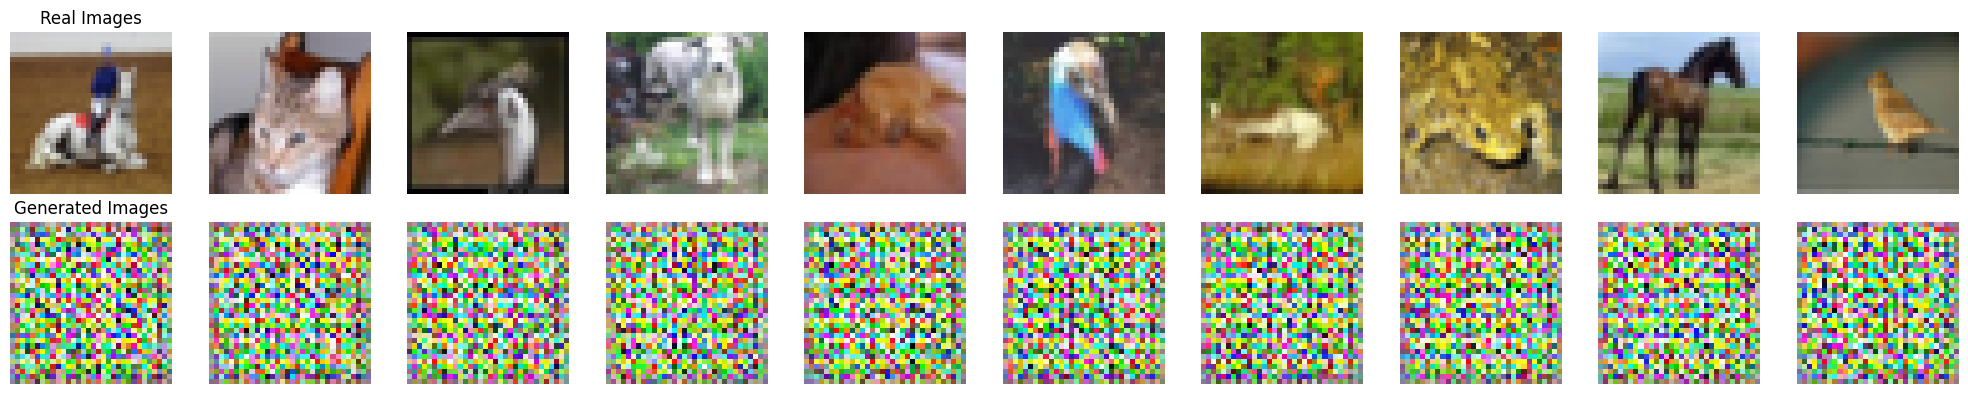

 FID : 529.6082679452763
Training started...
[Epoch 1/50] Loss D: -3.4501, Loss G: 1.8696 , FID score : 334.4571
[Epoch 2/50] Loss D: -2.0344, Loss G: 1.1127 , FID score : 258.4709
[Epoch 3/50] Loss D: -1.6792, Loss G: 0.9831 , FID score : 267.4774
[Epoch 4/50] Loss D: -1.3449, Loss G: 0.9143 , FID score : 278.2375
[Epoch 5/50] Loss D: -1.1796, Loss G: 1.0724 , FID score : 278.1544
[Epoch 6/50] Loss D: -0.9458, Loss G: 0.8395 , FID score : 249.2486
[Epoch 7/50] Loss D: -0.8324, Loss G: 0.8167 , FID score : 262.0506
[Epoch 8/50] Loss D: -0.7644, Loss G: 0.7398 , FID score : 265.5854
[Epoch 9/50] Loss D: -0.7136, Loss G: 0.7711 , FID score : 275.7763
[Epoch 10/50] Loss D: -0.6312, Loss G: 0.8112 , FID score : 272.0474
[Epoch 11/50] Loss D: -0.5909, Loss G: 0.6308 , FID score : 271.5804
[Epoch 12/50] Loss D: -0.5573, Loss G: 0.5378 , FID score : 250.3748
[Epoch 13/50] Loss D: -0.1871, Loss G: 0.3444 , FID score : 276.4176
[Epoch 14/50] Loss D: -0.1832, Loss G: 0.1074 , FID score : 265.126

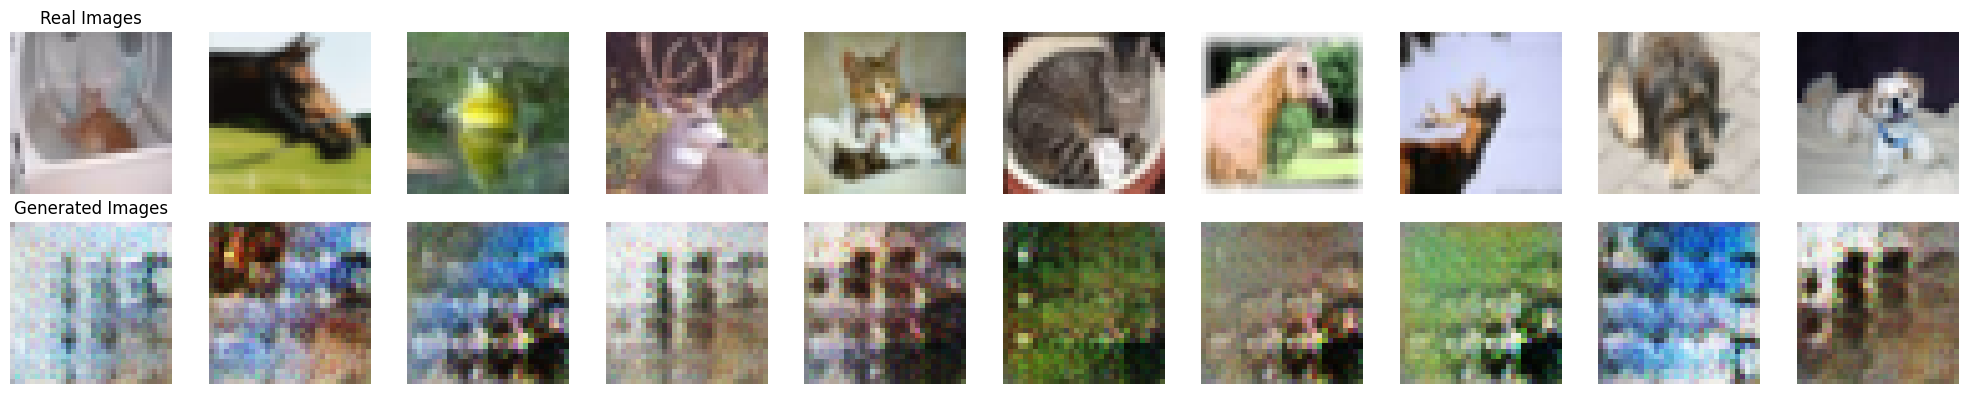

[Epoch 26/50] Loss D: -0.1768, Loss G: 0.2492 , FID score : 243.9267
[Epoch 27/50] Loss D: -0.1418, Loss G: 0.0548 , FID score : 216.2525
[Epoch 28/50] Loss D: -0.1547, Loss G: 0.2219 , FID score : 240.8280
[Epoch 29/50] Loss D: -0.1276, Loss G: 0.1620 , FID score : 228.4335
[Epoch 30/50] Loss D: -0.1157, Loss G: 0.0950 , FID score : 215.0798
[Epoch 31/50] Loss D: -0.1168, Loss G: 0.1744 , FID score : 218.7848
[Epoch 32/50] Loss D: -0.1169, Loss G: 0.1482 , FID score : 213.6471
[Epoch 33/50] Loss D: -0.1206, Loss G: 0.1583 , FID score : 213.0753
[Epoch 34/50] Loss D: -0.1111, Loss G: 0.3906 , FID score : 221.2419
[Epoch 35/50] Loss D: -0.1080, Loss G: 0.0552 , FID score : 216.2510
[Epoch 36/50] Loss D: -0.1308, Loss G: 0.0615 , FID score : 218.5501
[Epoch 37/50] Loss D: -0.1314, Loss G: 0.0259 , FID score : 224.3591
[Epoch 38/50] Loss D: -0.1438, Loss G: 0.2943 , FID score : 203.2756
[Epoch 39/50] Loss D: -0.1024, Loss G: 0.1532 , FID score : 227.7731
[Epoch 40/50] Loss D: -0.1090, Los

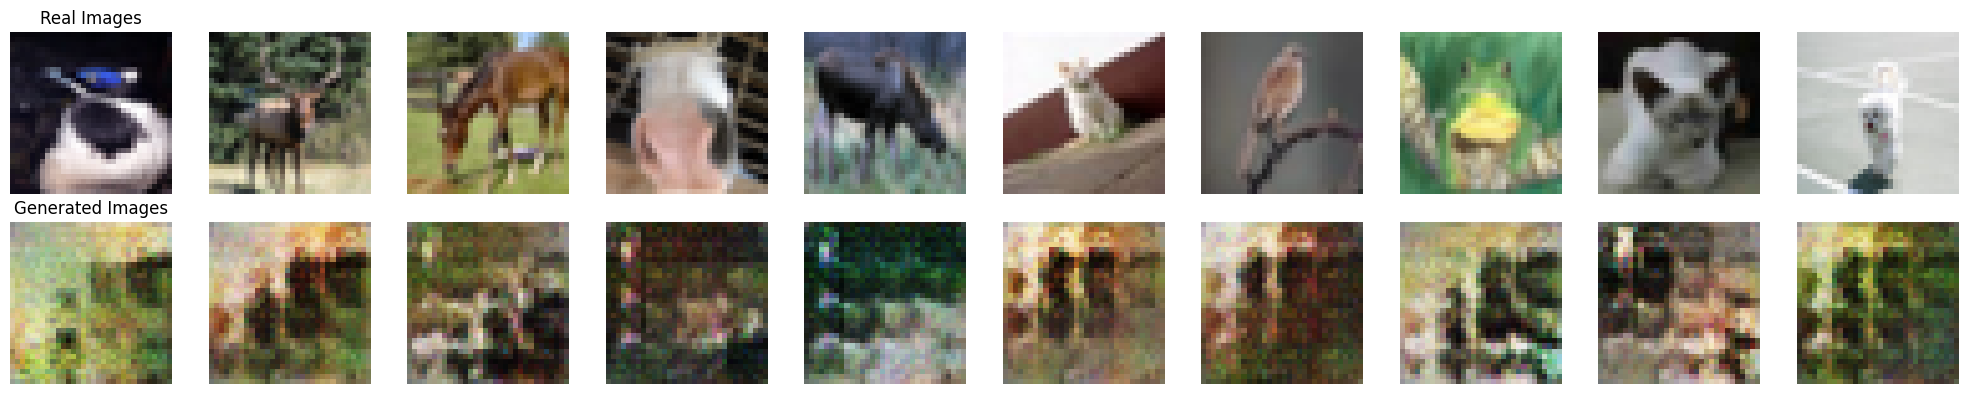

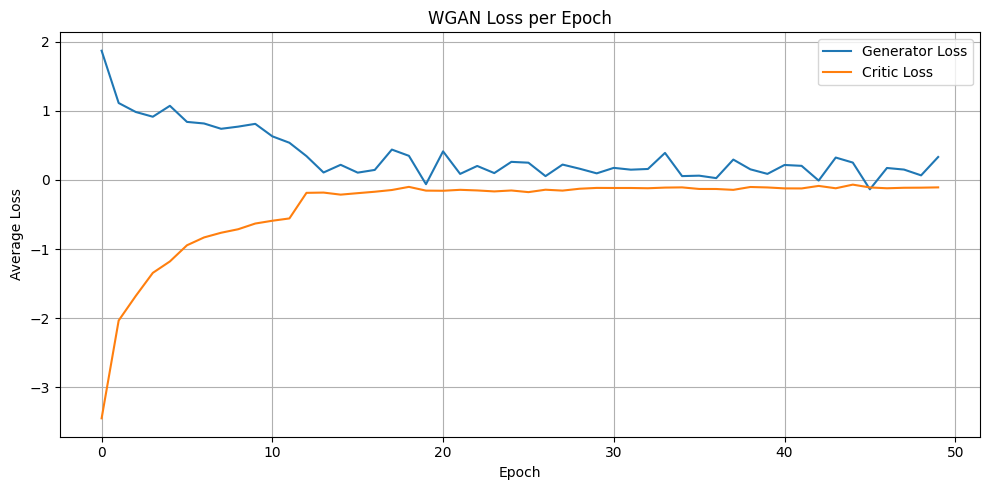

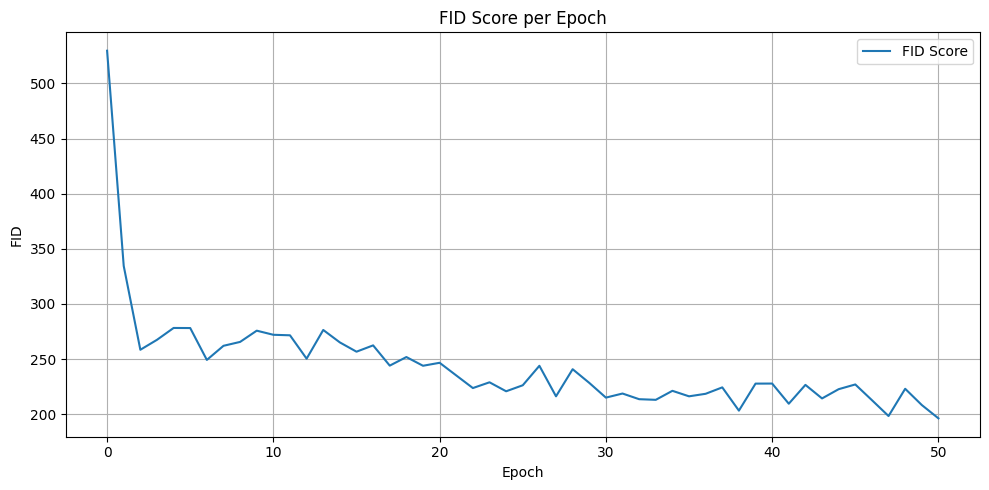

In [58]:
generator_4 = Generator_4(latent_dim).to(device)
critic_4 = Critic_4().to(device)
optimizer_g4 = optim.RMSprop(generator_4.parameters(), lr=lr)
optimizer_c4 = optim.RMSprop(critic_4.parameters(), lr=lr)

generator = generator_4.to(device)
batch_size = 20
noise = torch.randn(batch_size,latent_dim).to(device)
gen_imgs = generator(noise).to(device)
for i, (imgs, _) in enumerate(dataloader):
    real_imgs = imgs.to(device)
    break
    
print("Before Training...")
val = evaluate_fid(generator_4, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val}")
print("Training started...")

# Start training
fid_4 = train_WGAN(generator_4, critic_4, optimizer_g4, optimizer_c4, dataloader, device, latent_dim, n_critic , c , n_epochs , val)

**OBSERVATION_4**

1. Critc loss saturated too early
2. Generator is unstable 
3. FID score is poor and does not converge also the flactuation signifies the poor training 
4. Groupsort along with Weight Clipping can cause over constarining as both serves same purpose
5. grid like structure in generated image can signifies the poor Grouping 
4. Implementation of groupsort can cause error 

NOTE : A SEPERATE WORK HAS BEEN DONE ON GROUPSORT ACTIAVATION , THE ACTIVATION USED HERE MAY NOT WORKING PROPERLY

Before Training...


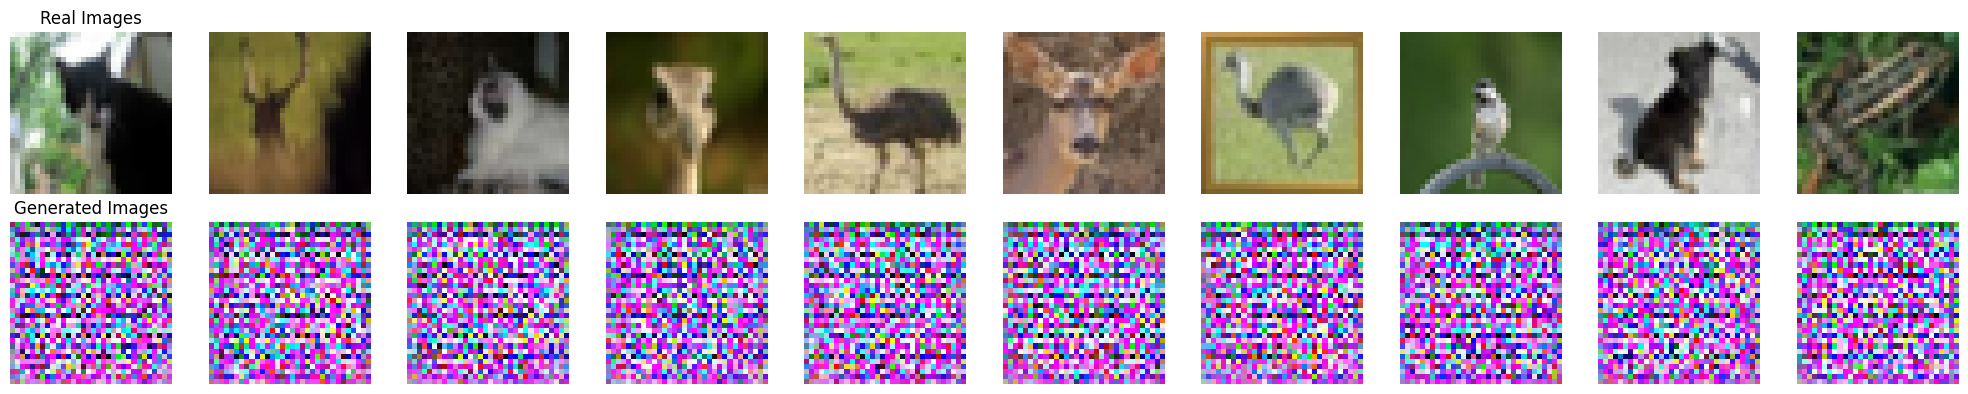

 FID : 486.5503066544576
Training started...
[Epoch 1/50] Loss D: -0.4318, Loss G: 0.2158 , FID score : 1027.8915
[Epoch 2/50] Loss D: -0.4426, Loss G: 0.2205 , FID score : 673.2473
[Epoch 3/50] Loss D: -0.4018, Loss G: 0.2035 , FID score : 247.2057
[Epoch 4/50] Loss D: -0.4196, Loss G: 0.2157 , FID score : 332.8623
[Epoch 5/50] Loss D: -0.4314, Loss G: 0.2168 , FID score : 346.6867
[Epoch 6/50] Loss D: -0.4342, Loss G: 0.2176 , FID score : 314.3089
[Epoch 7/50] Loss D: -0.4128, Loss G: 0.2141 , FID score : 268.9724
[Epoch 8/50] Loss D: -0.4236, Loss G: 0.2141 , FID score : 215.5993
[Epoch 9/50] Loss D: -0.4222, Loss G: 0.2136 , FID score : 206.0266
[Epoch 10/50] Loss D: -0.4164, Loss G: 0.2096 , FID score : 270.9979
[Epoch 11/50] Loss D: -0.4329, Loss G: 0.2173 , FID score : 212.7324
[Epoch 12/50] Loss D: -0.4212, Loss G: 0.2142 , FID score : 223.0886
[Epoch 13/50] Loss D: -0.4172, Loss G: 0.2078 , FID score : 221.7617
[Epoch 14/50] Loss D: -0.4209, Loss G: 0.2112 , FID score : 223.49

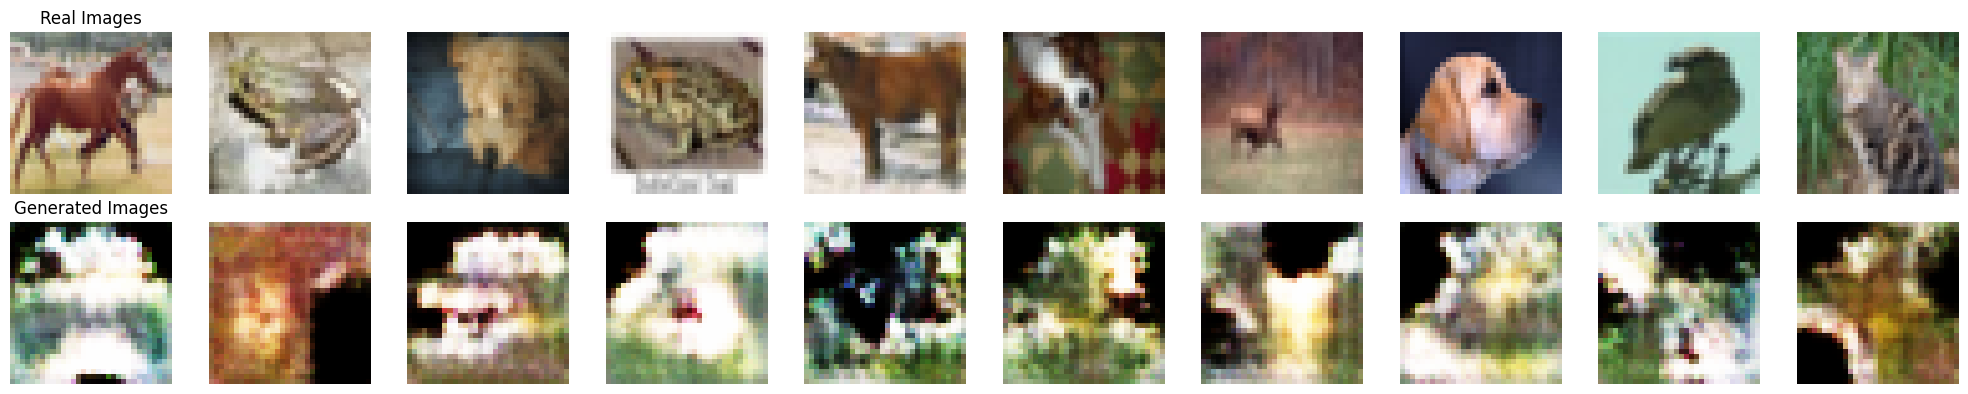

[Epoch 26/50] Loss D: -0.3846, Loss G: 0.2022 , FID score : 175.3024
[Epoch 27/50] Loss D: -0.3912, Loss G: 0.2011 , FID score : 175.1583
[Epoch 28/50] Loss D: -0.3825, Loss G: 0.1999 , FID score : 173.1476
[Epoch 29/50] Loss D: -0.3770, Loss G: 0.2009 , FID score : 163.5303
[Epoch 30/50] Loss D: -0.3831, Loss G: 0.2000 , FID score : 165.4977
[Epoch 31/50] Loss D: -0.3817, Loss G: 0.1988 , FID score : 167.6911
[Epoch 32/50] Loss D: -0.3825, Loss G: 0.2013 , FID score : 167.7731
[Epoch 33/50] Loss D: -0.3789, Loss G: 0.1991 , FID score : 153.9303
[Epoch 34/50] Loss D: -0.3764, Loss G: 0.1980 , FID score : 157.0399
[Epoch 35/50] Loss D: -0.3642, Loss G: 0.1939 , FID score : 174.4444
[Epoch 36/50] Loss D: -0.3640, Loss G: 0.1946 , FID score : 144.4974
[Epoch 37/50] Loss D: -0.3726, Loss G: 0.1963 , FID score : 143.8605
[Epoch 38/50] Loss D: -0.3549, Loss G: 0.1925 , FID score : 138.6423
[Epoch 39/50] Loss D: -0.3546, Loss G: 0.1947 , FID score : 135.0297
[Epoch 40/50] Loss D: -0.3560, Los

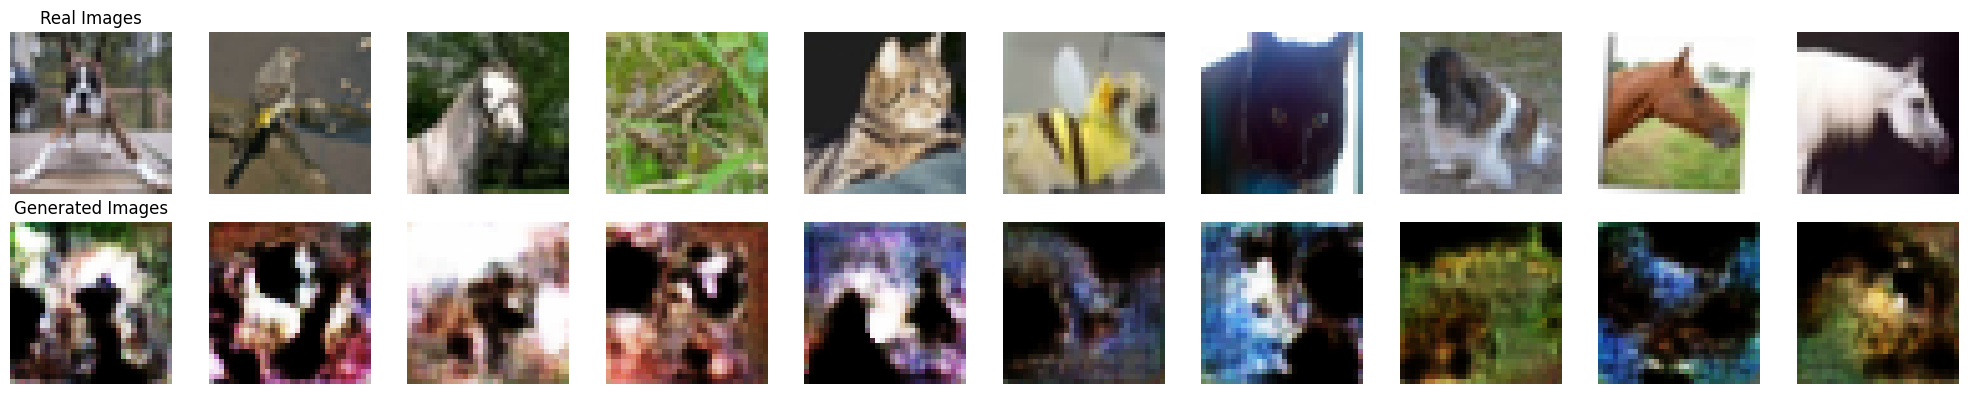

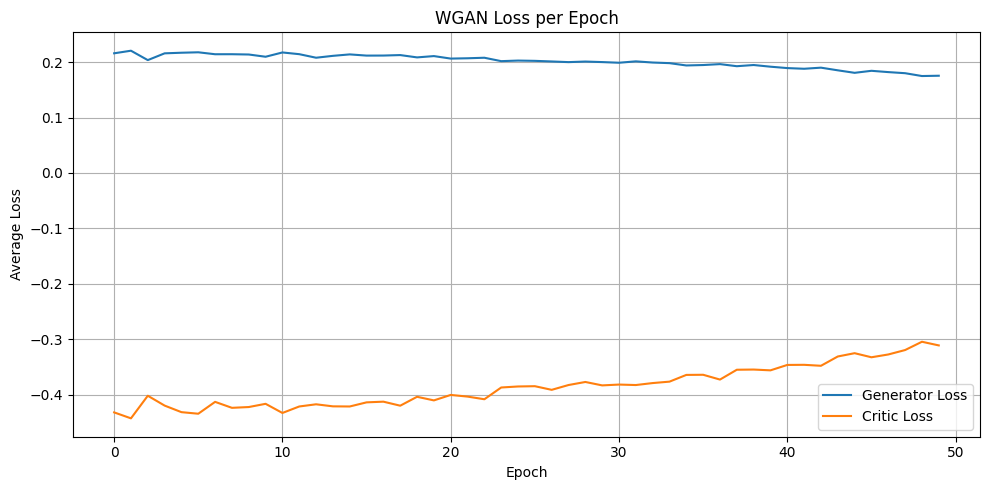

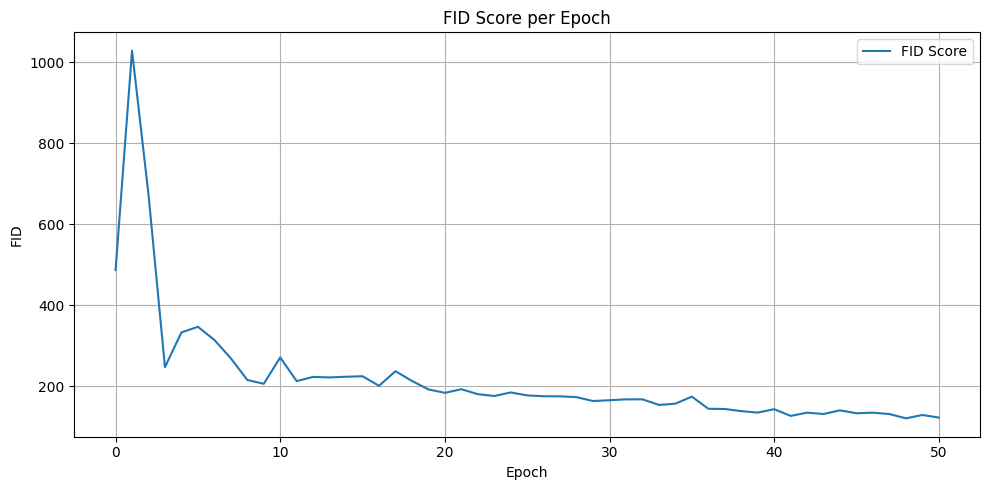

In [54]:
generator_5 = Generator_5(latent_dim).to(device)
critic_5 = Critic_5().to(device)
optimizer_g5 = optim.RMSprop(generator_5.parameters(), lr=lr)
optimizer_c5 = optim.RMSprop(critic_5.parameters(), lr=lr)

generator = generator_5.to(device)
batch_size = 20
noise = torch.randn(batch_size,latent_dim).to(device)
gen_imgs = generator(noise).to(device)
for i, (imgs, _) in enumerate(dataloader):
    real_imgs = imgs.to(device)
    break
    
print("Before Training...")
val = evaluate_fid(generator_5, dataloader, 5000 , 100 , latent_dim, device)
show_imgs(real_imgs, gen_imgs, n=10)
print(f" FID : {val}")
print("Training started...")

# Start training
fid_5 = train_WGAN(generator_5, critic_5, optimizer_g5, optimizer_c5, dataloader, device, latent_dim, n_critic , c , n_epochs , val)

**OBSERVATION_5**

1. Very poor performance , No convergence at all ... poor FID curve 
2. Losses are in non saturating manner 

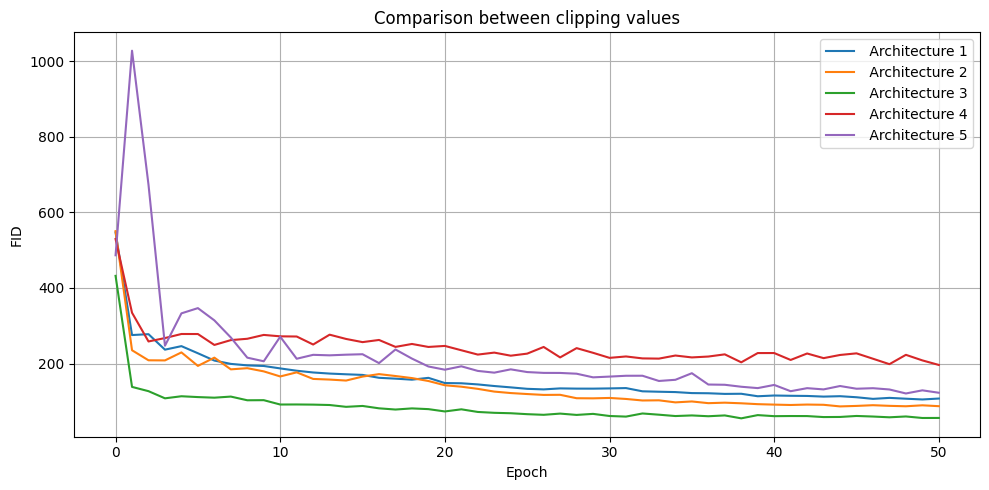

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(fid_1 ,label=' Architecture 1')
plt.plot(fid_2 ,label=' Architecture 2')
plt.plot(fid_3 ,label=' Architecture 3')
plt.plot(fid_4 ,label=' Architecture 4')
plt.plot(fid_5 ,label=' Architecture 5')
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("Comparison between Architectures for WGANs - Weight Clipping")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
import pickle

pickle.dump(fid_1, open('fid_1.pkl', 'wb'))
pickle.dump(fid_2, open('fid_2.pkl', 'wb'))
pickle.dump(fid_3, open('fid_3.pkl', 'wb'))
pickle.dump(fid_4, open('fid_4.pkl', 'wb'))
pickle.dump(fid_5, open('fid_5.pkl', 'wb'))  


***REMARK***

*Based on the observation and the fid curve ... Architecture 2 and 3 are selected for more tuning and 1,4,5 ar discarded for poor performance*